# Rapport Groupe de Travail Thématique

## Discrétisation du problème $ -\Delta u = f$ 

On s'intéresse à la discrétisation du problème suivante : 

$$ -\Delta u = f$$ 

sur l'intervalle $ \Omega = [0,1]\times [0,1]$ où $u = 0$ sur $ \partial \Omega$. 

La fonction $f$ est définie de la manière suivante : 

$$ f(x_1,x_2) = 6(1-3x_1+2x_1^2)(x_2-1)^3x_2 + 6(1-3x_2+2x_2^2)(x_1-1)^3x_1$$. 

On connait l'expression de u qui est la suivante : 

$$ u(x_1,x_2) = x_1x_2(x_1-1)^3(x_2-1)^3$$

Le but de ce rapport est de retrouver $u$ par différences finies. Pour cela nous écrirons une fonction qui retournera la matrice de discrétisation du Laplacien, nous résolverons ensuite le système et comparerons la solution approchée à celle exacte connue.

On commence par importer les packages dont nous avons besoin

In [121]:
import numpy as np
import scipy.sparse as sparse   # Algèbre linéaire creuse
from scipy.sparse.linalg import dsolve
from scipy.sparse.linalg import isolve
import matplotlib.pyplot as plt # Pour les graphiques
import scipy.sparse.linalg as sci
from mpl_toolkits.mplot3d import Axes3D

La fonction suivante permet d'écrire la matrice de la discrétisation du laplacien dans notre cas. On découpe l'intervalle $[0,1]\times[0,1]$ en $N$ intervalles en $x$ et en $y$. Elle retourne une matrice de taille $(N+1)\times(N+1)$.

In [122]:
def matrix_lap(N):
    """Retourne une matrice qui discrétise le laplacien de u dans le domaine Omega = [0,1]x[0,1], 
    découpé en N intervalles en x et y. La matrice finale est une matrice scipy.sparse CSR matrix. 
    Cette matrice est de taille (N+1)*(N+1)"""

    h = 1./N
    h2 = h*h

    #On note les inconnues de 0 à Nx suivant x et 0 à Ny suivant y. La taille du problème est donc (Nx+1)*(Ny+1).

    #Cela correspond à x_i = i*h et y_j = j*h et la numérotation (i,j) --> k := (N+1)*j+i.

    taille = (1+N)*(1+N)

    diags = np.zeros((5,taille))

    #Diagonale principale
    diags[2,:] = 1.
    diags[2, N+2:taille - (N+2)] = -4./h2
    diags[2, np.arange(2*N+1, taille, N+1)] = 1.
    diags[2, np.arange(2*N+2, taille, N+1)] = 1.
              
    #Diagonale "-1"
    diags[1,N+1:taille-(N+1)] = 1./h2
    diags[1, np.arange(2*N, taille, N+1)] = 0.
    diags[1, np.arange(2*N+1, taille, N+1)] = 0.
    
    #Diagonale "+1"
    diags[3, N+3:taille-(N+1)] = 1./h2
    diags[3, np.arange(2*N+2, taille, N+1)] = 0.
    diags[3, np.arange(2*N+3, taille, N+1)] = 0.

    #Diagonale "-(N+1)"
    diags[0, 1 : taille - (2*N+3)] = 1./h2
    diags[0, np.arange(N,taille,N+1)] = 0.
    diags[0, np.arange(N+1,taille,N+1)] = 0.

    #Diagonale "+(N+1)"
    diags[4, taille - N*N + 2 : taille - 1] = 1./h2
    diags[4, np.arange(taille - N*N + 1 + N ,taille,N+1)] = 0.
    diags[4, np.arange(taille - N*N + 2 + N ,taille,N+1)] = 0.

    #Construction de la matrice creuse
    A = sparse.spdiags(diags,[-(N+1),-1,0,1,(N+1)],taille,taille, format = "csr")

    return A

Munis de cette fonction, il ne nous reste plus qu'à résoudre le problème en suivante l'ordre de numérotation des sommets qui est le suivant : $k = i + (N+1)\times j, \quad i = 0,\ldots,N, \quad j = 0,\ldots,N$

Voyons ce que nous retourne la fonction matrix_lap pour N = 2 et N = 3.

In [123]:
print(matrix_lap(2).todense())

[[  1.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   1.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   1.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   1.   0.   0.   0.   0.   0.]
 [  0.   4.   0.   4. -16.   4.   0.   4.   0.]
 [  0.   0.   0.   0.   0.   1.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   1.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   1.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   1.]]


In [124]:
print(matrix_lap(3).todense())

[[  1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   9.   0.   0.   9. -36.   9.   0.   0.   9.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   9.   0.   0.   9. -36.   9.   0.   0.   9.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   0.   9.   0.   0.   9. -36.   9.   0.   0.   9.
    0.   0.]
 [  0.   0.   0.   0.   0.   0.   9.   0.   0.   9. -36.   9.   0.   0.
    9.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0

Par suite, nous écrivons le code pour la fonction $f$ et notre solution exacte $u$

In [125]:
def f(x1,x2):
    return 6.*(1.-3.*x1+2.*x1**2)*((x2-1.)**3)*x2 + 6.*(1.-3.*x2+2.*x2**2)*((x1-1.)**3)*x1

def u(x1,x2):
    return x1*x2*((x1-1.)**3)*((x2-1))**3

On va résoudre le problème pour N = 100. Le maillage en $x$ et en $y$ sera initialisé dans chaque fonction

In [126]:
N = 100

x = np.linspace(0,1,N+1)
y = np.linspace(0,1,N+1)

On écrit la fonction qui sort la solution approchée du problème

In [127]:
def sol_disc(N):
    
    x = np.linspace(0,1,N+1)
    y = np.linspace(0,1,N+1)
    
    F = np.zeros((N+1)*(N+1))   #Allocation mémoire de f

    for i in np.arange(1,N):    #(1,N) car on veut que ce soit 0 sur les bords
        for j in np.arange(1,N):
            k = i + j*(N+1)
            F[k] = f(x[i],y[j])

    U = np.zeros((N+1)*(N+1))   #matrice pour la solution
    A = matrix_lap(N)
        
    U = sci.spsolve(A,F)
    
    return U
    

Et on affiche finalement la solution

Text(0.5, 0.92, 'Solution discrétisée')

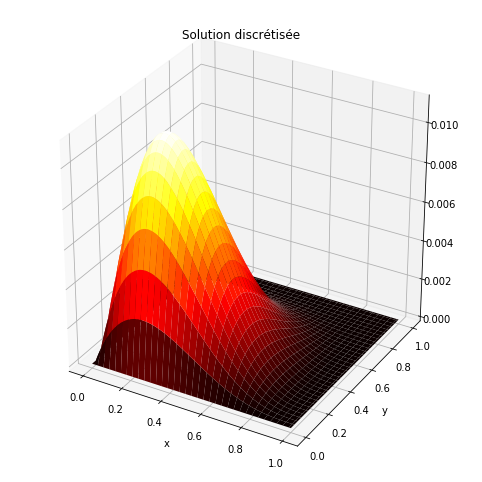

In [128]:
U = sol_disc(N)
fig = plt.figure(figsize = [6.5,6.5])
ax = Axes3D(fig)
X,Y = np.meshgrid(x,y)
ax.plot_surface(X,Y, U.reshape((N+1,N+1)), cmap='hot')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Solution discrétisée")

On va la comparer avec le graphique de la solution exacte par la fonction suivante

Text(0.5, 0.92, 'Solution exacte')

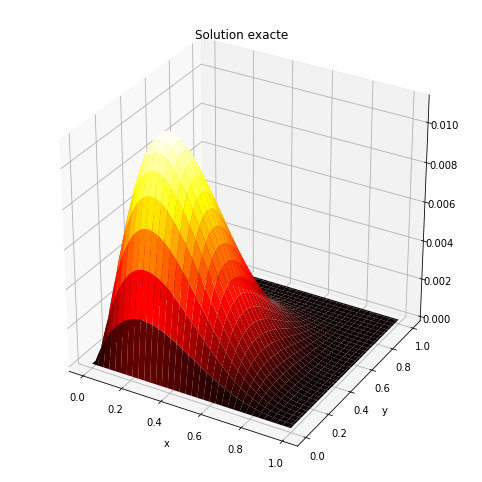

In [129]:
def sol_exacte(N):
    
    x = np.linspace(0,1,N+1)
    y = np.linspace(0,1,N+1)
    
    V = np.zeros((N+1)*(N+1))   #Allocation mémoire sol exacte
    for i in np.arange(N+1):
        for j in np.arange(N+1):
            k = i + j*(N+1)
            V[k] = u(x[i],y[j])

    return V

V = sol_exacte(N)

fig2 = plt.figure(figsize = [6.5,6.5])
ax = Axes3D(fig2)
X,Y = np.meshgrid(x,y)
ax.plot_surface(X,Y,V.reshape((N+1,N+1)),cmap = 'hot')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Solution exacte")

On peut remarquer que les graphes sont très ressemblants, ce qui est une bonne nouvelle. Cependant, nous allons calculer l'erreur entre la solution approchée et exacte afin de vérifier la justesse de notre discrétisation.

In [130]:
def erreur_eucl(A,E,N):
    return np.sqrt(np.sum((E-A)**2)/((N+1)**2))

err1 = erreur_eucl(U,V,N)
print("{:8s} {:12s}".
    format("Taille", "Erreur demandée"))
print("{:8d} {:12.5e}".
    format((N+1)*(N+1), err1))

Taille   Erreur demandée
   10201  9.55422e-07


In [131]:
def erreur_abs(A,E,N):
    return np.max(np.abs(E - A))

err2 = erreur_abs(U,V,N)
print("{:8s} {:12s}".
    format("Taille", "Erreur absolue"))
print("{:8d} {:12.5e}".
    format((N+1)*(N+1), err2))

Taille   Erreur absolue
   10201  1.85769e-06


Nous allons finalement tracer les graphes de convergence pour les deux erreurs. Pour cela on utilise le code suivant

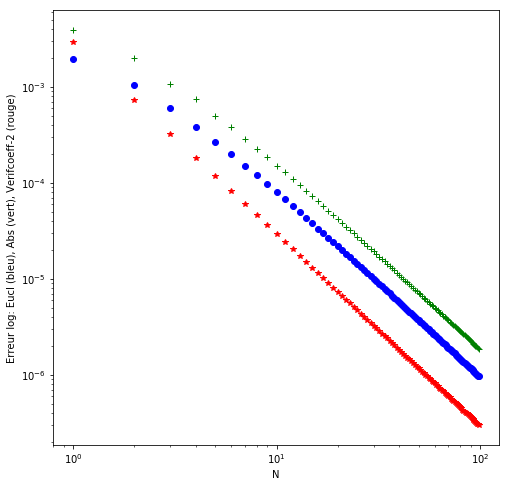

In [132]:
def aff(x,b):
    return b*(x**(-2)) 

def graphe_erreur(N):
    
    tab_err = np.zeros(N)
    tab_err2 = np.zeros(N)
    ERR = np.zeros(N)
    
    fig = plt.figure(figsize = [8,8])
    
    for z in range(1,N):        
        F = sol_disc(z+1)
        G = sol_exacte(z+1)
        
        tab_err[z] = erreur_eucl(F,G,z)
        tab_err2[z] = erreur_abs(F,G,z) 
        ERR[z] = aff(z,(tab_err2[1]+tab_err[1])/2)      
        
        plt.plot(z,tab_err[z],color='blue',marker='o')
        plt.plot(z,tab_err2[z],color='green',marker='+')
        plt.plot(z,ERR[z],color='r',marker='*')
        
        plt.xscale("log")
        plt.yscale("log")
        plt.xlabel('N')
        plt.ylabel('Erreur log: Eucl (bleu), Abs (vert), Verifcoeff-2 (rouge)')

    plt.show()

graphe_erreur(N)

## Interpolation du problème par des fonctions polynômiales

Dans cette partie, nous cherchons à changer la valeur de la solution sur les bords. On s'intéresse à la discrétisation du problème suivante sur un domaine $\Omega = [0,1] \times [0,1]$ : $$ -\Delta u = 0 $$

Avec $u$ valant $x(x-\frac{1}{2})\alpha$ sur la première moitié du bord bas (c'est à dire pour $x \leq 0.5$) puis $0$ et $u$ valant $0$ sur la première moitié du bord haut et après $(x-1)(x-\frac{1}{2})\beta$. L'interpolation dépend donc également de deux paramètres réels $\alpha$ et $\beta$.


On commence par importer les différents modules et définir les fonctions pour le bord haut et le bord bas.

In [133]:
import numpy as np
import scipy.sparse as sparse   # Algèbre linéaire creuse
import matplotlib.pyplot as plt # Pour les graphiques
from scipy.sparse.linalg import spsolve
from mpl_toolkits.mplot3d import Axes3D

In [134]:
def fb(x,y,alpha):
    return x*(x-(1./2.))*alpha

def fh(x,y,beta):
    return (x-1.)*(x-(1./2.))*beta

Et on discrétise le problème de la façon suivante

In [135]:
def sol_disc_inter(N, alpha, beta):
    x = np.linspace(0,1,N+1)
    y = np.linspace(0,1,N+1)

    F = np.zeros((N+1)*(N+1))      #Matrice pour stocker les valeurs de f, avec les interpolés

    for i in np.arange(0,N+1):   
        for j in np.arange(0,N+1):
            k = i + j*(N+1)        
            if (i <= (N/2.) and j == 0):
                F[k] = fb(x[i],y[j],alpha)
            elif (i >= (N/2.) and j == N):
                F[k] = fh(x[i],y[j],beta)
                

    U = np.zeros((N+1)*(N+1))       #Matrice pour la solution
    A = matrix_lap(N)               #Matrice de discrétisation du Laplacien
        
    U = spsolve(A,F)            #On résoud par le solveur spsolve
    
    return U


Finalement, on procède à l'affichage pour une valeur de $N = 200$, $\alpha = -1$, $\beta = -1$

Text(0.5, 0, 'y')

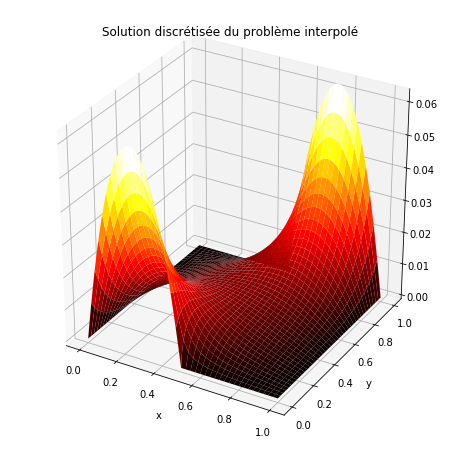

In [136]:
N = 200

x = np.linspace(0,1,N+1)
y = np.linspace(0,1,N+1)

U = sol_disc_inter(N,-1,-1)

fig = plt.figure(figsize = [8,8])
ax = fig.add_subplot(111 ,projection='3d')
X,Y = np.meshgrid(x,y)
ax.plot_surface(X,Y, U.reshape((N+1,N+1)), cmap='hot')
plt.title("Solution discrétisée du problème interpolé")
plt.xlabel("x")
plt.ylabel("y")

## Résolution de l'équation de la chaleur 

Dans cette partie, on s'intéresse à la résolution de l'équation de la chaleur, c'est à dire à la discrétisation du problème suivant sur un domaine $\Omega = [0,1]\times[0,1]$ : 

$$
\left\{
    \begin{array}{ll}
        \dfrac{\partial u}{\partial t} = \Delta u &{sur }\quad \Omega \\
        u = 0 &\mbox{sur } \quad \partial u  
    \end{array}
\right.
$$

Pour faire cela, nous allons utiliser une méthode de discrétisation implicite. Nous obtenons le calcul suivant :

$$
\dfrac{U^{n+1} - U^n}{\delta t} = AU^{n+1}
$$

Et l'expression finale : 

$$
U^{n+1} = (I - \delta t A)^{-1}U^n
$$

La stratégie adoptée pour coder ce problème sera la suivante. Dans un premier temps, nous allons écrire la matrice de $(I -\delta t A)$ en s'inspirant de celle de discrétisation du Laplacien définie en début de rapport. Dans un second temps, nous ajouterons la boucle temporelle et nous finirons par afficher le résultat final.

On commence par importer tous les modules nécessaires : 

In [137]:
import numpy as np
import scipy.sparse as sparse   #Algèbre linéaire creuse
import matplotlib.pyplot as plt #Pour les graphiques
from scipy.sparse.linalg import spsolve
from mpl_toolkits.mplot3d import Axes3D

La matrice de $(I - \delta t A)$ sera une matrice sparse de taille $(N+1)\times(N+1)$. Elle regroupera tous les points du maillage et nous permettra de résoudre le système linéaire. La fonction suivante prendra en paramètre le nombre $N$ d'intervalles et la pas de temps $\delta t$.

In [138]:
def matrix_lap2(N,dt):
    """Retourne la matrice de (I -dtA) dans le domaine Omega = [0,1]x[0,1] 
    découpé en N intervalles en x et y. La matrice finale est une matrice scipy.sparse CSR matrix. 
    Cette matrice est de taille (N+1)*(N+1)"""

    h = 1./N
    h2 = h*h

    #On note les inconnues de 0 à Nx suivant x et 0 à Ny suivant y. La taille du problème est donc (Nx+1)*(Ny+1).

    #Cela correspond à x_i = i*h et y_j = j*h et la numérotation (i,j) --> k := (N+1)*j+i.

    taille = (1+N)*(1+N)

    diags = np.zeros((5,taille))

    #Diagonale principale
    diags[2,:] = 1.
    diags[2, N+2:taille - (N+2)] = 1 + ((4*dt)/h2)
    diags[2, np.arange(2*N+1, taille, N+1)] = 1.
    diags[2, np.arange(2*N+2, taille, N+1)] = 1.
              
    #Diagonale "-1"
    diags[1,N+1:taille-(N+1)] = -dt/h2
    diags[1, np.arange(2*N, taille, N+1)] = 0.
    diags[1, np.arange(2*N+1, taille, N+1)] = 0.
    
    #Diagonale "+1"
    diags[3, N+3:taille-(N+1)] = -dt/h2
    diags[3, np.arange(2*N+2, taille, N+1)] = 0.
    diags[3, np.arange(2*N+3, taille, N+1)] = 0.

    #Diagonale "-(N+1)"
    diags[0, 1 : taille - (2*N+3)] = -dt/h2
    diags[0, np.arange(N,taille,N+1)] = 0.
    diags[0, np.arange(N+1,taille,N+1)] = 0.

    #Diagonale "+(N+1)"
    diags[4, taille - N*N + 2 : taille - 1] = -dt/h2
    diags[4, np.arange(taille - N*N + 1 + N ,taille,N+1)] = 0.
    diags[4, np.arange(taille - N*N + 2 + N ,taille,N+1)] = 0.

    #Construction de la matrice creuse
    A = sparse.spdiags(diags,[-(N+1),-1,0,1,(N+1)],taille,taille, format = "csc")

    return A


Regardons ce que nous affiche la matrice $A$ pour $N = 2$ et un $\delta t = 0.1$

In [139]:
A = matrix_lap2(2,0.1)
print(A.todense())

[[ 1.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   1.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   1.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   1.   0.   0.   0.   0.   0. ]
 [ 0.  -0.4  0.  -0.4  2.6 -0.4  0.  -0.4  0. ]
 [ 0.   0.   0.   0.   0.   1.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   1.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   1.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   1. ]]


Finalement, on écrit le code pour résoudre le système linéaire. Nous avons décidé de créer un tableau des temps en 2 dimensions, dans lequel on stockera la solution à chaque temps $t$. Cela permettra à l'utilisateur de choisir quel temps il voudra afficher dans un intervalle $[0,T]$. Dans le cadre de ce rapport, nous afficherons seulement pour $t = 0$ et $t = T$. On obtient la fonction suivante

In [177]:
def chaleur0(N,dt,t):

    x = np.linspace(0,1,N+1)
    y = np.linspace(0,1,N+1)

    taille1 = (N+1)*(N+1)

    T = np.zeros((t+1,taille1))          #Initialisation de la solution finale. On met des 0 sur les bords
                                         #valider les conditions initiales et on initialise le reste à 1 pour ne 
                                         #pas obtenir une solution triviale. On verra dans la suite ce qu'il se passe
                                         #quand on initialise u par une autre fonction.
    T[0,N+2:taille1 - N-2] = 1.
    T[0,np.arange(2*N+1, taille1, N+1)] = 0
    T[0,np.arange(2*N+2, taille1, N+1)] = 0

    for i in range (t):                 #Boucle temporelle
         T[i+1,:] = sci.spsolve(matrix_lap2(N,dt),T[i,:])

    return T 

Finalement on va procéder à l'affichage de la solution discrétisée. On se propose ici d'afficher la solution au temps $1$ et au temps $T$. Cependant l'utilisateur peut changer la valeur du paramètre pour l'afficher au temps $t \in [0,T]$. On va afficher ici pour une valeur de $N = 200$, $\delta = 0.01$ et $T = 10 $

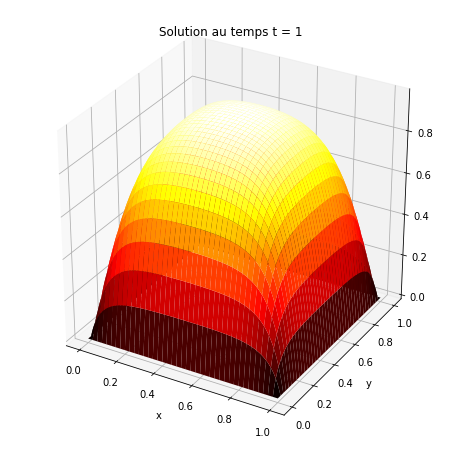

In [178]:
N = 200
t = 10

T = chaleur0(N,0.01,t)

x = np.linspace(0,1,N+1)
y = np.linspace(0,1,N+1)

fig = plt.figure(figsize = [8,8])

ax = fig.add_subplot(111, projection = '3d')
X,Y = np.meshgrid(x,y)
ax.plot_surface(X,Y,T[1,:].reshape(N+1,N+1) ,cmap='hot')
plt.title("Solution au temps t = 1")
plt.xlabel("x")
plt.ylabel("y")
    
plt.show()

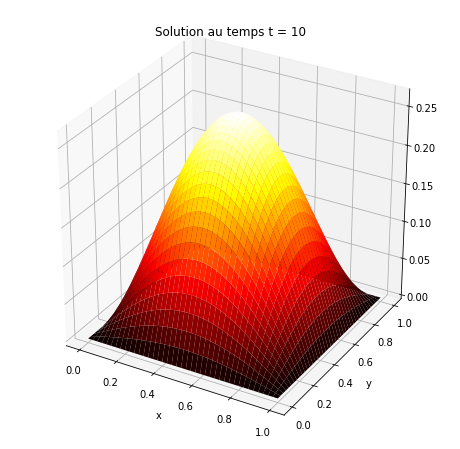

In [179]:
fig5 = plt.figure(figsize = [8,8])

ax = fig5.add_subplot(111, projection = '3d')
X,Y = np.meshgrid(x,y)
ax.plot_surface(X,Y,T[t,:].reshape(N+1,N+1) ,cmap='hot')
plt.title("Solution au temps t = "+str(t))
plt.xlabel("x")
plt.ylabel("y")
    
plt.show()

On observe clairement un "applatissement" de la courbe qui tend vers une fonction gaussienne qui se révèle être la solution analytique de l'équation de diffusion de la chaleur. Dans la suite de ce rapport, nous allons développer ce concept de diffusion sur une fonction $u$ donnée. 

## Résolution de l'équation de la chaleur pour une solution $u$ donnée

Dans cette partie, on s'intéresse à la résolution de l'équation de la chaleur avec une fonction $u$ donnée, c'est à dire à la discrétisation du problème suivant sur un domaine $\Omega = [0,1]\times[0,1]$ : 

$$
\left\{
    \begin{array}{ll}
        \dfrac{\partial u}{\partial t} = \Delta u &{sur }\quad \Omega \\
        u = 0 &\mbox{sur } \quad \partial u  
    \end{array}
\right.
$$

où $$ u(x_1,x_2) = x_1x_2(x_1-1)^3(x_2-1)^3$$

Pour faire cela, nous allons utiliser une méthode de discrétisation implicite comme précédemment. Nous obtenons le même calcul qu'avant. Le seul changement résidera dans le code de la fonction $u$. On commence par écrire la fonction dont nous avons besoin 

In [180]:
def u(x1,x2):
    return x1*x2*((x1-1.)**3)*((x2-1))**3

Puis on écrit le code final, qui ressemblera fortement au code précédent

In [181]:
def chaleur_ex(N,dt,t):
    x = np.linspace(0,1,N+1)
    y = np.linspace(0,1,N+1)
    
    taille1 = (N+1)*(N+1)

    V = np.zeros((t+1,taille1))                             #Allocation mémoire sol exacte
    
    for i in np.arange(N+1):                                #Calcul de la solution en tout point du maillage
        for j in np.arange(N+1):
            k = i + j*(N+1)
            V[0,k] = u(x[i],y[j])

    for i in range (t):                                    #Boucle temporelle
        V[i+1,:] = sci.spsolve(matrix_lap2(N,dt),V[i,:])

    return V

On affiche finalement le résultat au temps pour des valeurs $N = 200$, $\delta t = 0.01$. Selon les informations données en cours, la valeur maximale de la fonction pour $t = 1$ est de $max(u) = 0.007773$ et pour $t = 2$ on obtient $max(u) = 0.005619$. Regardons si nous retrouvons ces résultats.

Tout d'abord pour $t = 1$.

Le maximum est atteint pour 0.007773079850730673


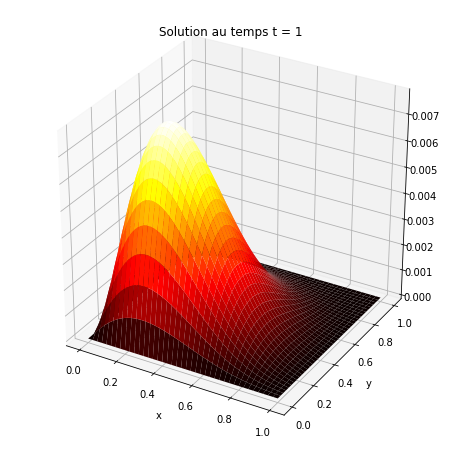

In [145]:
N = 200
t = 1

x = np.linspace(0,1,N+1)
y = np.linspace(0,1,N+1)

V = chaleur_ex(N,0.01,t)

print('Le maximum est atteint pour '+str(np.max(V[t,:])))

fig = plt.figure(figsize = [8,8])
    
ax = fig.add_subplot(111, projection = '3d')
X,Y = np.meshgrid(x,y)
ax.plot_surface(X,Y,V[1,:].reshape(N+1,N+1) ,cmap='hot')
plt.title("Solution au temps t = 1")
plt.xlabel("x")
plt.ylabel("y")

plt.show()

Si l'on regarde pour $t = 2$ on obtient le résultat suivant

Le maximum est atteint pour 0.0056197497221826655


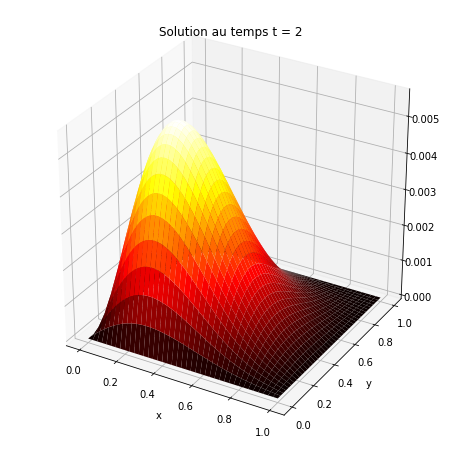

In [146]:
N = 200
t = 2

x = np.linspace(0,1,N+1)
y = np.linspace(0,1,N+1)

V = chaleur_ex(N,0.01,t)

print('Le maximum est atteint pour '+str(np.max(V[t,:])))

fig = plt.figure(figsize = [8,8])
    
ax = fig.add_subplot(111, projection = '3d')
X,Y = np.meshgrid(x,y)
ax.plot_surface(X,Y,V[2,:].reshape(N+1,N+1) ,cmap='hot')
plt.title("Solution au temps t = 2")
plt.xlabel("x")
plt.ylabel("y")

plt.show()

Finalement nous retrouvons bien les résultats donnés lors du cours, ce qui valide notre approximation.

## La fonction distance

Dans cette partie, nous allons écrire le code pour la rédaction de la fonction distance. 

In [216]:
def chaleurdist(N,dt,t):
    x = np.linspace(0,1,N+1)
    y = np.linspace(0,1,N+1)

    taille1 = (N+1)*(N+1)
    T = np.ones((t+1,taille1))          #Initialisation de la solution finale
    T[0,N+2:taille1 - N-2] = 0
    T[0,np.arange(2*N+1, taille1, N+1)] = 1.
    T[0,np.arange(2*N+2, taille1, N+1)] = 1.


    for i in range (t):
        T[i+1,:] = sci.spsolve(matrix_lap2(N,dt),T[i,:])

    return T

In [218]:
def dist(N,dt):

    x = np.linspace(0,1,N+1)
    y = np.linspace(0,1,N+1)

    T = chaleurdist(N,dt,1)

    dist  = - np.log(T[1,:])*np.sqrt(dt)
    
    return dist

On affiche la solution. Selon les informations données en cours, nous devrions voir s'afficher une pyramide avec comme valeur maximale $max(dist) = 0.4935556$, pour $N = 1000$ et $\delta t = 0.00001$.

La valeur maximale de la fonction distance est 0.4935559135325694


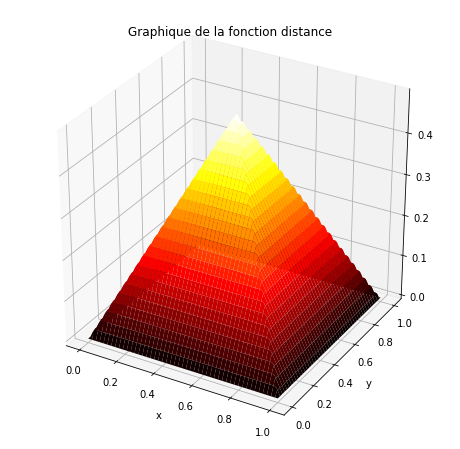

In [220]:
N = 1000

DIST = dist(N,0.00001)

x = np.linspace(0,1,N+1)
y = np.linspace(0,1,N+1)

print('La valeur maximale de la fonction distance est '+str(np.max(DIST)))

fig = plt.figure(figsize = [8,8])
    
ax = fig.add_subplot(111, projection = '3d')
X,Y = np.meshgrid(x,y)
ax.plot_surface(X,Y,DIST.reshape(N+1,N+1) ,cmap='hot')
plt.title("Graphique de la fonction distance")
plt.xlabel("x")
plt.ylabel("y")

plt.show()

On remarque finalement que la valeur obtenue est bien celle attendue.